In [2]:
#import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    AddDefaultVisualization,
    ConnectPlanarSceneGraphVisualizer,
    IrisFromCliqueCoverOptions,
    IrisInConfigurationSpaceFromCliqueCover,
    RandomGenerator,
    RigidTransform,
    RobotDiagramBuilder,
    SceneGraphCollisionChecker,
    StartMeshcat,
    VPolytope,
)
from pydrake.geometry.optimization import GraphOfConvexSetsOptions, HPolyhedron, Point
from pydrake.planning import GcsTrajectoryOptimization
from scipy.spatial import ConvexHull

# from manipulation import running_as_notebook
# from manipulation.utils import ConfigureParser

# if running_as_notebook:
#     mpld3.enable_notebook()

In [3]:
import sys
sys.path.append('..')
from gcs.gcs_star import GCSStar

In [4]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


# Environment setup

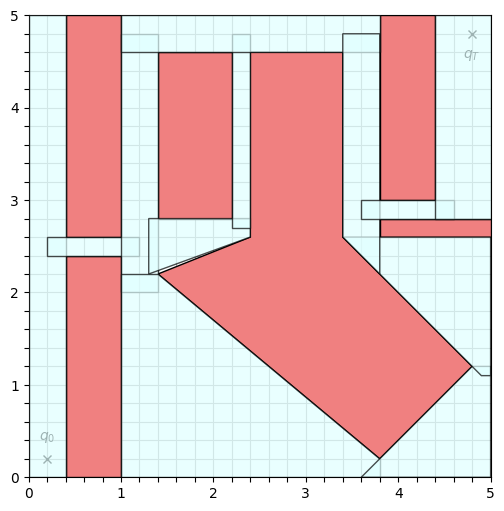

In [47]:
sr2 = np.sqrt(2)

# obstacles
obstacles = [
    np.array(
        [
            [3.4, 2.6],
            [3.4, 4.6],
            [2.4, 4.6],
            [2.4, 2.6],
            [1.4, 2.2],
            [3.8, 0.2],
            [4.8, 1.2],
        ]
    ),
    np.array([[1.4, 2.8], [2.2, 2.8], [2.2, 4.6], [1.4, 4.6]]),
    np.array([[1.0, 2.6], [1.0, 5.0], [0.4, 5.0], [0.4, 2.6]]),
    np.array([[1.0, 2.4], [1.0, 0.0], [0.4, 0.0], [0.4, 2.4]]),
    np.array([[3.8, 3.0], [3.8, 5.0], [4.4, 5.0], [4.4, 3.0]]),
    np.array([[3.8, 2.8], [3.8, 2.6], [5.0, 2.6], [5.0, 2.8]]),
]

# vertices of the safe regions
vertices = [
    np.array([[0.4, 0.0], [0.4, 5.0], [0.0, 5.0], [0.0, 0.0]]),
    np.array([[0.2, 2.4], [1.2, 2.4], [1.2, 2.6], [0.2, 2.6]]),
    np.array([[1.4, 2.0], [1.4, 4.8], [1.0, 4.8], [1.0, 2.0]]),
    np.array([[1.3, 2.2], [2.4, 2.6], [2.4, 2.8], [1.3, 2.8]]),
    np.array([[2.2, 2.7], [2.4, 2.7], [2.4, 4.8], [2.2, 4.8]]),
    np.array([[1.4, 2.2], [1.0, 2.2], [1.0, 0.0], [3.8, 0.0], [3.8, 0.2]]),
    np.array([[3.8, 4.6], [3.8, 5.0], [1.0, 5.0], [1.0, 4.6]]),
    np.array([[5.0, 0.0], [5.0, 1.2], [4.8, 1.2], [3.8, 0.2], [3.6, 0.0]]),
    np.array([[3.4, 2.6], [4.9, 1.1], [5.0, 1.1], [5.0, 2.6]]),
    np.array([[3.4, 2.6], [3.8, 2.2], [3.8, 4.8], [3.4, 4.8]]),
    np.array([[3.6, 2.8], [4.6, 2.8], [4.6, 3.0], [3.6, 3.0]]),
    np.array([[5.0, 2.8], [5.0, 5.0], [4.4, 5.0], [4.4, 2.8]]),
]

x_min = np.min(np.vstack(vertices), axis=0)
x_max = np.max(np.vstack(vertices), axis=0)

x_start = np.array([0.2, 0.2])
x_goal = np.array([4.8, 4.8])


def make_hpolytope(V):
    ch = ConvexHull(V)
    return HPolyhedron(ch.equations[:, :-1], -ch.equations[:, -1])


regions = [make_hpolytope(V) for V in vertices]


def environment_setup():
    plt.figure(figsize=(6, 6))
    plt.axis("square")

    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])

    tick_gap = 0.2

    def n_ticks(x_min, x_max):
        return round((x_max - x_min) / tick_gap) + 1

    x_ticks = np.linspace(x_min[0], x_max[0], n_ticks(x_min[0], x_max[0]))
    y_ticks = np.linspace(x_min[1], x_max[1], n_ticks(x_min[1], x_max[1]))
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    label_gap = 0.5

    def keep_label(t):
        return np.isclose(t % label_gap, 0) or np.isclose(t % label_gap, label_gap)

    x_labels = [int(t) if keep_label(t) else "" for t in x_ticks]
    y_labels = [int(t) if keep_label(t) else "" for t in y_ticks]
    plt.gca().set_xticklabels(x_labels)
    plt.gca().set_yticklabels(y_labels)

    plt.grid()


def plot_trajectory(traj):
    plt.figure(figsize=(6, 6))

    for O in obstacles:
        plt.fill(*O.T, fc="lightcoral", ec="k", zorder=4)

    plt.plot(*traj.value(traj.start_time()), "kx")
    plt.plot(*traj.value(traj.end_time()), "kx")
    times = np.linspace(traj.start_time(), traj.end_time(), 1000)
    waypoints = traj.vector_values(times)
    plt.plot(*waypoints, "b", zorder=5)

    plt.axis("square")
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks(range(6))
    plt.yticks(range(6))
    plt.grid(1)


def plot_velocity(traj):
    vel = traj.MakeDerivative()

    plt.figure(figsize=(6, 4))

    for i in range(vel.get_number_of_segments()):
        v = vel.segment(i)
        times = np.linspace(v.start_time(), v.end_time(), 500)
        values = v.vector_values(times)
        plt.plot(times, values[0], color="tab:blue")
        plt.plot(times, values[1], color="tab:orange")

    plt.xlim([traj.start_time(), traj.end_time()])
    plt.xticks(np.arange(int(np.ceil(traj.end_time() / 2))) * 2)
    plt.yticks(np.linspace(qdot_min, qdot_max, 5))
    plt.xlabel("Time $t$")
    plt.ylabel("Velocity $\dot{q}$")
    plt.grid()

environment_setup()

for O in obstacles:
    plt.fill(*O.T, fc="lightcoral", ec="k", zorder=4)

plt.plot(*x_start, "kx")
plt.plot(*x_goal, "kx")

plt.text(0.2, 0.35, "$q_0$", ha="center", va="bottom")
plt.text(4.8, 4.65, "$q_T$", ha="center", va="top");

for V in vertices:
    plt.fill(*V.T, fc="lightcyan", alpha=0.7, ec="k", zorder=4)

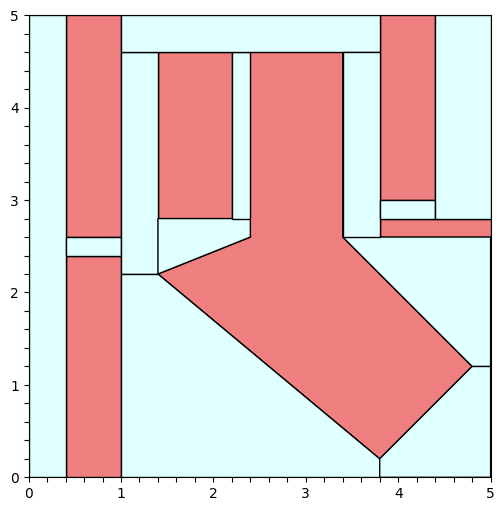

In [17]:
environment_setup()

for O in obstacles:
    plt.fill(*O.T, fc="lightcoral", ec="k", zorder=4)

plt.plot(*x_start, "kx")
plt.plot(*x_goal, "kx")

plt.text(0.2, 0.35, "$q_0$", ha="center", va="bottom")
plt.text(4.8, 4.65, "$q_T$", ha="center", va="top");

for V in vertices:
    plt.fill(*V.T, fc="lightcyan", ec="k", zorder=4)

In [ ]:
environment_setup()

for V in vertices:
    plt.fill(*V.T, fc="lightcyan", ec="k", zorder=4)

# Minimum-distance problem

INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 3 unique paths, discarded 97 duplicate paths.
INFO:drake:Finished 3 rounding solutions with Clarabel.


result.is_success() = True
[0.0, 10.00561696708043, 14.445726758550986, 18.568442351585773, 23.00764330036282, 27.439600517058842, 31.784979548351178, 35.91385872350876, 40.285607164150875, 50.2912241312313]


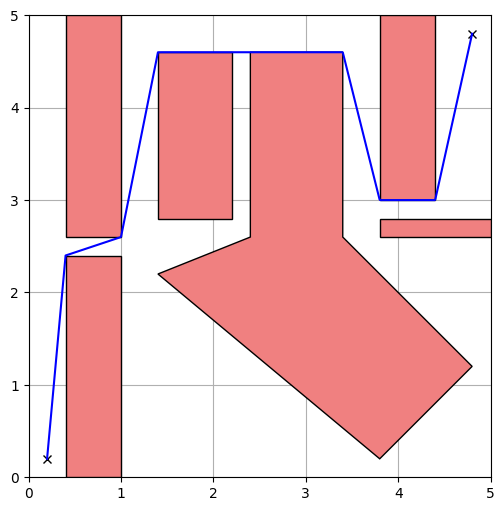

In [48]:
qdot_min = -1
qdot_max = 1


def solve_min_distance(order=1):
    trajopt = GcsTrajectoryOptimization(2)
    gcs_regions = trajopt.AddRegions(regions, order=order)
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddPathLengthCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    options = GraphOfConvexSetsOptions()
    [traj, result] = trajopt.SolvePath(source, target, options)
    print(f"result.is_success() = {result.is_success()}")
    if result.is_success():
        print(traj.get_segment_times())
        plot_trajectory(traj)


solve_min_distance()

INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 2 unique paths, discarded 98 duplicate paths.
INFO:drake:Finished 2 rounding solutions with Clarabel.


result.is_success() = True
[0.0, 10.035016393974505, 14.459594114634307, 18.601453662314917, 22.727231680293773, 26.887191416060812, 31.267252640151966, 35.45635503682065, 39.801742958620224, 43.943852160261756, 48.31340321807276, 58.348419612047266]


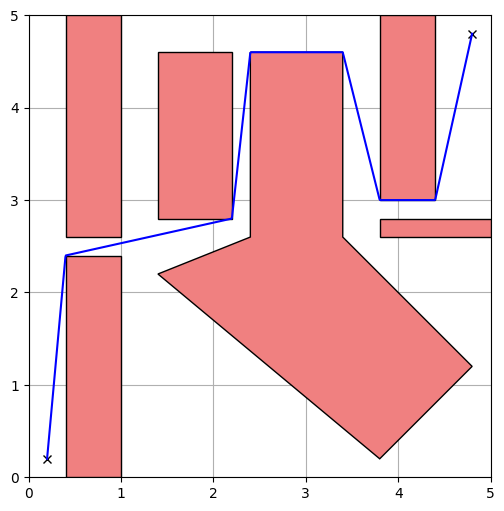

In [9]:
qdot_min = -1
qdot_max = 1


def solve_min_distance_STAR(order=1):
    trajopt = GCSStar(2)
    gcs_regions = trajopt.AddRegions(regions, order=order)
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddPathLengthCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    options = GraphOfConvexSetsOptions()
    [traj, result] = trajopt.SolvePath(source, target, options)
    print(f"result.is_success() = {result.is_success()}")
    if result.is_success():
        print(traj.get_segment_times())
        plot_trajectory(traj)


solve_min_distance_STAR()

# Minimum-time problem

In [11]:
qdot_min = -1
qdot_max = 1


def solve_min_time(order, continuity_order):
    trajopt = GcsTrajectoryOptimization(2)
    gcs_regions = trajopt.AddRegions(regions, order=order)

    
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddTimeCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    for o in range(1, continuity_order + 1):
        print(f"adding C{o} constraints")
        trajopt.AddContinuityConstraints(o)
    options = GraphOfConvexSetsOptions()
    [traj, result] = trajopt.SolvePath(source, target, options)

    return traj, result

INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 3 unique paths, discarded 97 duplicate paths.
INFO:drake:Finished 3 rounding solutions with CLP.


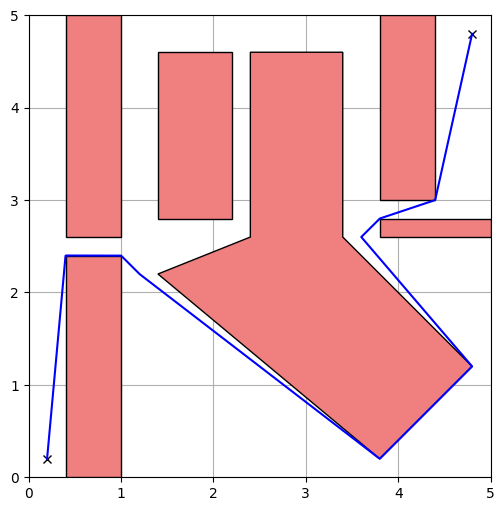

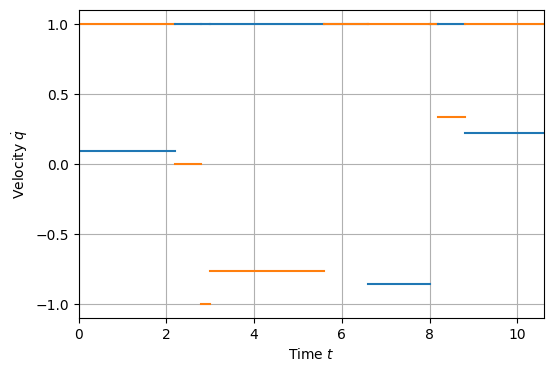

In [12]:
order = 1
continuity = 0
traj, results = solve_min_time(order, continuity)

plot_trajectory(traj)

plot_velocity(traj)

In [14]:
qdot_min = -1
qdot_max = 1


def solve_min_time_STAR(order, continuity_order):
    trajopt = GCSStar(2)
    gcs_regions = trajopt.AddRegions(regions, order=order)
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddTimeCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    for o in range(1, continuity_order + 1):
        print(f"adding C{o} constraints")
        trajopt.AddContinuityConstraints(o)
    options = GraphOfConvexSetsOptions()
    [traj, result] = trajopt.SolvePath(source, target, options)

    return traj, result

INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 3 unique paths, discarded 97 duplicate paths.
INFO:drake:Finished 3 rounding solutions with CLP.


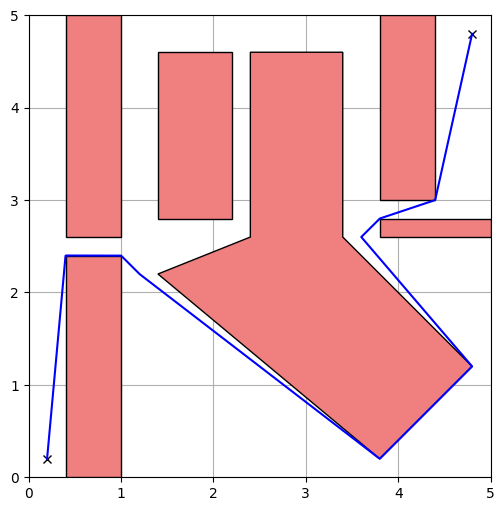

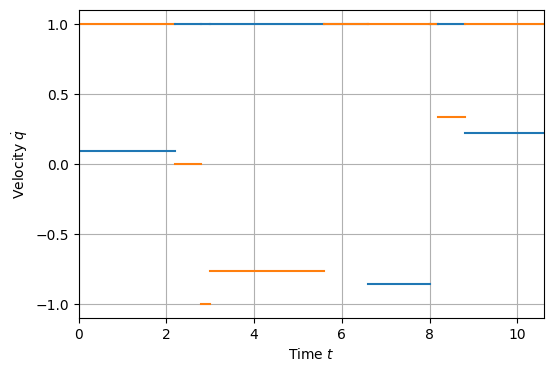

In [16]:
order = 1
continuity = 0
traj, results = solve_min_time_STAR(order, continuity)

plot_trajectory(traj)

plot_velocity(traj)

adding C1 constraints
adding C2 constraints
adding C3 constraints
adding C4 constraints


INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 5 unique paths, discarded 10 duplicate paths.
INFO:drake:Finished 5 rounding solutions with SNOPT.


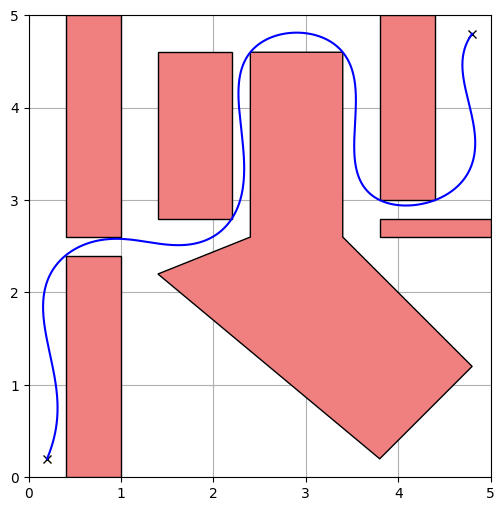

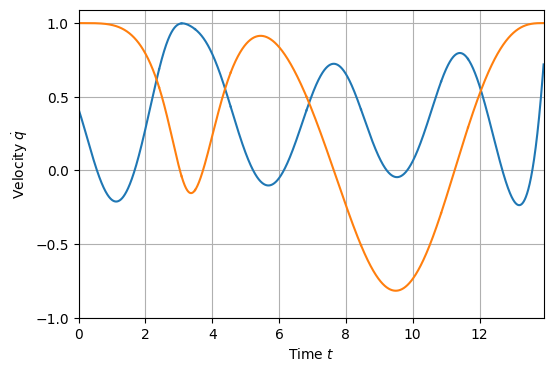

In [9]:
order = 5
continuity = 4
traj, results = solve_min_time(order, continuity)

plot_trajectory(traj)

plot_velocity(traj)

INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 5 unique paths, discarded 10 duplicate paths.


adding C1 constraints
adding C2 constraints
adding C3 constraints
adding C4 constraints


INFO:drake:Finished 5 rounding solutions with SNOPT.


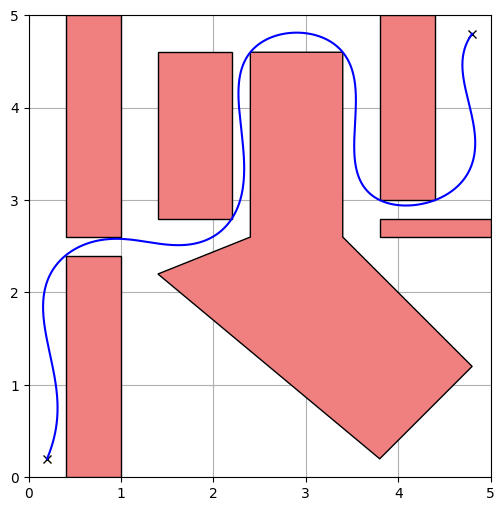

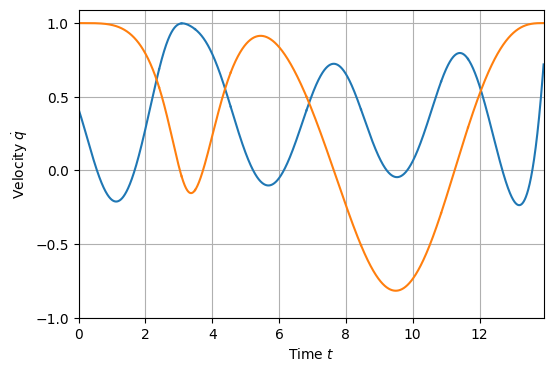

In [17]:
order = 5
continuity = 4
traj, results = solve_min_time_STAR(order, continuity)

plot_trajectory(traj)

plot_velocity(traj)

In [26]:
import inspect
print(inspect.getsource(solve_min_time_STAR))

def solve_min_time_STAR(order, continuity_order):
    trajopt = GCSStar(2)
    gcs_regions = trajopt.AddRegions(regions, order=order)
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddTimeCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    for o in range(1, continuity_order + 1):
        print(f"adding C{o} constraints")
        trajopt.AddContinuityConstraints(o)
    options = GraphOfConvexSetsOptions()
    [traj, result] = trajopt.SolvePath(source, target, options)

    return traj, result



## Same environment, now using MultibodyPlant/SceneGraph

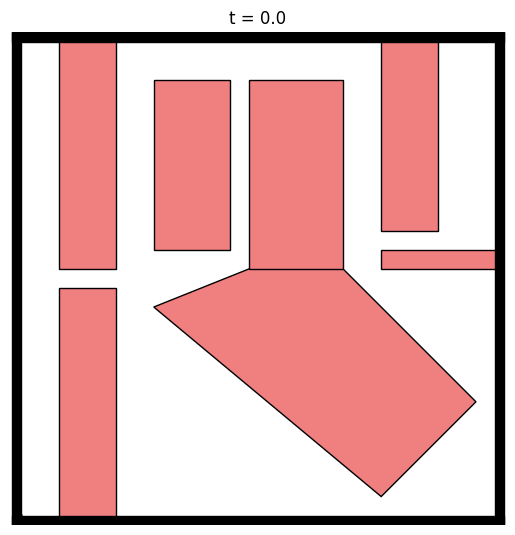

INFO:drake:Allocating contexts to support implicit context parallelism 10
INFO:drake:Using default max clique solver MaxCliqueSolverViaGreedy.
INFO:drake:Current Fraction of Domain Covered = 0
INFO:drake:IrisFromCliqueCover Iteration 1/100
INFO:drake:Clique added to queue. There are 147/200 points left to cover.
INFO:drake:Clique added to queue. There are 130/200 points left to cover.
INFO:drake:Clique added to queue. There are 110/200 points left to cover.
INFO:drake:Clique added to queue. There are 105/200 points left to cover.
INFO:drake:Clique added to queue. There are 98/200 points left to cover.
INFO:drake:Clique added to queue. There are 95/200 points left to cover.
INFO:drake:Finished adding cliques. Total of 6 clique added. Number of cliques left to process = 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurat

RuntimeError: The current center of the IRIS region is within options.configuration_space_margin of being infeasible.  Check your sample point and/or any additional constraints you've passed in via the options. The configuration space surrounding the sample point must have an interior.

In [25]:
def BuildEnvironment():
    builder = RobotDiagramBuilder(time_step=0)
    parser = builder.parser()
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://manipulation/simple_2d_cspace.xml")
    builder.plant().Finalize()

    visualizer = ConnectPlanarSceneGraphVisualizer(
        builder.builder(),
        builder.scene_graph(),
        xlim=[-0.1, 5.1],
        ylim=[-0.1, 5.1],
        T_VW=np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1]]),
    )

    AddDefaultVisualization(builder.builder(), meshcat)

    return builder.Build()


def CliqueCoverDemo():
    meshcat.SetCameraTarget([0, 0, 0])
    meshcat.Set2dRenderMode(
        X_WC=RigidTransform([0, 0, 5]), xmin=0, xmax=5, ymin=0, ymax=5
    )
    diagram = BuildEnvironment()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    generator = RandomGenerator(1234)
    checker = SceneGraphCollisionChecker(
        model=diagram,
        robot_model_instances=[diagram.plant().GetModelInstanceByName("robot")],
        edge_step_size=0.01,
    )
    options = IrisFromCliqueCoverOptions()
    options.num_points_per_visibility_round = 200 if running_as_notebook else 10
    options.coverage_termination_threshold = 0.96 if running_as_notebook else 0.2
    # See https://github.com/RobotLocomotion/drake/issues/21343
    regions = IrisInConfigurationSpaceFromCliqueCover(checker, options, generator, [])
    diagram.GetSubsystemByName("planar_scenegraph_visualizer")
    for region in regions:
        V = VPolytope(region)
        hull = ConvexHull(V.vertices().T)
        plt.fill(
            V.vertices()[0, hull.vertices],
            V.vertices()[1, hull.vertices],
            fc="lightcyan",
            ec="k",
            zorder=4,
        )
    plt.axis("square")
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks(range(6))
    plt.yticks(range(6))
    plt.grid(1)

    trajopt = GcsTrajectoryOptimization(2)
    gcs_regions = trajopt.AddRegions(regions, order=1, h_min=0.01)
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddTimeCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    options = GraphOfConvexSetsOptions()
    [traj, result] = trajopt.SolvePath(source, target, options)
    print(f"result.is_success() = {result.is_success()}")
    if result.is_success():
        plot_trajectory(traj)
        plot_velocity(traj)


CliqueCoverDemo()